In [1]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#pip install --upgrade peft

In [3]:
# Load peft config for pre-trained checkpoint etc.
#peft_model_id = "results"
config = PeftConfig.from_pretrained("M2_LR_S2_EXT3_EXP10_model")

# load base LLM model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, "M2_LR_S2_EXT3_EXP10_model", use_dora = False, device_map={"":0})
model.eval()

print("Peft model loaded")

'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Peft model loaded


/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [4]:
from datasets import load_from_disk, DatasetDict
from random import randrange


# Load dataset from the hub and get a sample
#dataset = load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank')
dataset = DatasetDict({
    'train': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_3/train'),
    'validation': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_3/validation'),
    'test': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_3/test')
})
sample = dataset['test'][randrange(len(dataset["test"])-300)]


In [5]:
input_ids = tokenizer(sample["description"], return_tensors="pt", truncation=True).input_ids.cpu()
# with torch.inference_mode():
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.9)
print(f"input sentence: {sample['description']}\n{'---'* 20}")

print(f"summary:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]}")

input sentence: fig . fig . fig . fig . each groove or channel 30 receives an edge portion of the flexible member or sidewall 17 of the drum 16 , as shown in fig . 2 . 2 . 2 . 2 . summary of the invention a dryer drum is defined by an endless flexible wall member in combination with front and rear bulkheads of the cabinet , thus facilitating a drum which is not limited to a cylindrical shape . thus as the drum rotates baffles 18 , which may be attached to wall member 17 , carry items being dried from the bottom to the upper portion of the drum and allow them to fall once again to the bottom . 3 and fig . second , an elliptical drum can provide for a larger higher access opening to the drum as can be seen in fig . 3 . 3 . 3 . 2 and 3 the member 17 extends substantially between a fixed rear drum end wall 19 and a front drum end wall 20 , as best seen in fig . other drum shapes and configurations may be advantageous in any particular case depending upon such variables as cabinet size and 

In [6]:
outputs

tensor([[    2,     0,   250,  3841,   254, 12638,    16,  6533,    30,    41,
         12210,  9538,  2204,   919,    11,  4069,    19,   760,     8,  5081,
          8533, 16560,     9,     5,  5892,     6,  4634, 23373,    10, 12638,
            61,    16,    45,  1804,     7,    10, 44996,  2028, 36057,  3989,
             4,    20, 12638,    16,    67,  6533,    11,     5, 22827, 39441,
            19,    41, 43568,  3569,  3989,    30,     5,  5297,     7,    61,
             5,  9538, 46605,  1250, 18627,    29,    19,     5,   538, 31799,
             9,     5, 28041,  1588,  1090,  9148, 32039,     6,  5418,  2584,
         13568,   352,    15,     5, 33139,  1634,   145, 16380,    31,     5,
          2576,     7,     5,  2853,  4745,     9,     5, 12638,     8,  1157,
           106,     7,  1136,   683,   456,     7,     5,  2576,     4,     2]])

In [7]:
import evaluate
import numpy as np
from datasets import load_from_disk
from tqdm import tqdm

# Metric
metric = evaluate.load("rouge")

def evaluate_peft_model(sample,max_target_length=512):
    # generate summary
    outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cpu(), do_sample=True, top_p=0.9, max_new_tokens=max_target_length)
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(), skip_special_tokens=True)
    # decode eval sample
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(sample['labels'] != -100, sample['labels'], tokenizer.pad_token_id)
    labels = tokenizer.decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    return prediction, labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
# load test dataset from distk
test_dataset = load_from_disk("./tokenized_data_S2_EXT4/test").with_format("torch")

# run predictions
# this can take ~45 minutes
predictions, references = [] , []
for sample in tqdm(test_dataset):
    p,l = evaluate_peft_model(sample)
    predictions.append(p)
    references.append(l)

# compute metric
rogue = metric.compute(predictions=predictions, references=references, use_stemmer=True)

# print results
print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

# Rogue1: 50.386161%
# rouge2: 24.842412%
# rougeL: 41.370130%
# rougeLsum: 41.394230%

  0%|          | 0/2259 [00:00<?, ?it/s]

100%|██████████| 2259/2259 [8:29:29<00:00, 13.53s/it]     


Rogue1: 43.655491%
rouge2: 20.192785%
rougeL: 30.594020%
rougeLsum: 30.775380%


In [9]:
# Extracting Rouge scores
rouge1_score = rogue['rouge1'] * 100
rouge2_score = rogue['rouge2'] * 100
rougeL_score = rogue['rougeL'] * 100
rougeLsum_score = rogue['rougeLsum'] * 100

# Plotting the Rouge scores
labels = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'Rouge-Lsum']
scores = [rouge1_score, rouge2_score, rougeL_score, rougeLsum_score]

(0.0, 100.0)

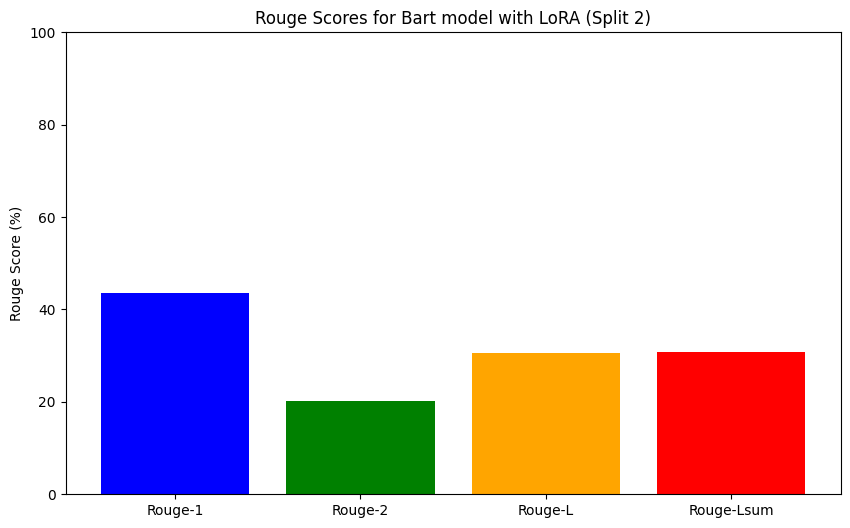

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Rouge Score (%)')
plt.title('Rouge Scores for Bart model with LoRA (Split 2)')
plt.ylim(0, 100)